# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from nistats.hemodynamic_models import glover_hrf

In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(threshold=sys.maxsize)
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

**Basic parameters**

In [3]:
HCP_DIR =  "c:/users/frauke/downloads/hcp_task/"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Loading region information
Downloading either dataset will create the regions.npy file, which contains the region name and network assignment for each parcel.

In [4]:
regions = np.load(f"{HCP_DIR}regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

# Data load 
Helper function

In [5]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id-1]
    ev_file = f"{HCP_DIR}subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

In [6]:
def condition_frames(run_evs, skip=0):
    """Identify timepoints corresponding to a given condition in each run.
    Args:
        run_evs (list of dicts) : Onset and duration of the event, per run
        skip (int) : Ignore this many frames at the start of each trial, to account
        for hemodynamic lag
    
    Returns:
        frames_list (list of 1D arrays): Flat arrays of frame indices, per run
        
    """
    frames_list = []
    for ev in run_evs:
        try:
            # Determine when trial starts, rounded down
            start = np.floor(ev["onset"] / (TR/10)).astype(int)
            
            #Use trial duration to determine how many frames to include for trial
            duration = np.ceil(ev["duration"] / (TR/10)).astype(int)
            
            # Take the range of frames that correspond to this specific trial
            if type(start) == np.ndarray:
                frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]
            else:
                frames = [start+np.arange(skip,duration)]
            
            frames_list.append(np.concatenate(frames))
            #print('ev-file is not empty')
        except KeyError:
            print('ev-file is empty')

    return frames_list

In [ ]:
def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

In [ ]:
def make_design_matrix(task,conditions,sampel_rate):
    """
    Creates a design matrix for given tasks and conditions.
    
    Args:
        task: string of specific task of experiment
        conditions: list of conditions, which should be included in design matrix
        sample_rate: int of how much the frames should be upsampled
    """
    
    #ignore warnings from genfromtxt
    warnings.filterwarnings("ignore", message="genfromtxt")
    #create instances of events and design_matrix
    evs = []
    ts = load_single_timeseries(subject,get_image_ids(task)[0])
    design_matrix = np.zeros((ts.shape[1]*sample_rate,len(conditions)))
    #loop through all conditions and set a 1 in design matrix for every time point condition is fullfilled
    for n, cond in enumerate(conditions):
        frames= []
        ev = [load_evs(subject,task,cond)]
        frames = condition_frames(ev[0],skip=0)
        design_matrix[frames,n] = 1
    #loop through design matrix columns and delete design matrix if at least one row has no entries
    for i in range(len(conditions)):
        if np.sum(design_matrix,axis=0)[i]==0:
            design_matrix = []
            print(subject,' has not made enough errors')
            break
    

In [44]:
canon_hrf = glover_hrf(tr=TR, oversampling=10)

# Define timepoints corresponding to HRF
t_hrf = np.linspace(0, np.floor(32/TR).astype(int), np.round(32/TR * 10).astype(int), endpoint=False)

#plt.figure(figsize=(11, 4))
#plt.plot(t_hrf, canon_hrf)
#plt.grid()
#plt.ylabel('Amplitude (A.U.)', fontsize=15)
#plt.xlabel('Time (seconds)', fontsize=15)
#plt.title('Canonical ("Glover"") HRF', fontsize=20)
#plt.show()

In [30]:
def hrf_convo(design_matrix,bf):
    """
    Takes designmatrix upsampled to TR/TReso and convolves it with canonical HRF
    
    Args
    design_matrix: C * VolTreso ndarray; indicates closest Tr/TReso timepoint where an event started for specific regressor
    bf: basis function - will usually be the hrf; 1D array

    Returns
    design_matrix_conv: CVol array with predicted BOLD response
    """
    try:
        design_matrix_pad=np.pad(design_matrix,((0,len(bf)),(0, 0))) # pad with zeros, so we can fit the hrf also for very late events
        design_matrix_conv=np.empty(design_matrix_pad.shape) # prepare convolved design matrix
    
        for C in range(len(design_matrix[1])): # for each condition C
            design_matrix_conv[:,C]=np.convolve(design_matrix_pad[:len(design_matrix_pad[0])-(len(bf)+1),C],bf) #convolute with design with bf

        design_matrix_downsampled=design_matrix_conv[:len(design_matrix_pad[0])-(len(bf)+2),:] # cut back the padded stuff

        design_matrix_downsampled=design_matrix_downsampled[0::10,:] # pick every time-point where we have a volume
    
        return design_matrix_downsampled
    except ValueError:
        print('subject has no design matrix')
    

In [35]:
design_matrix_GLM = hrf_convo(design_matrix,canon_hrf)

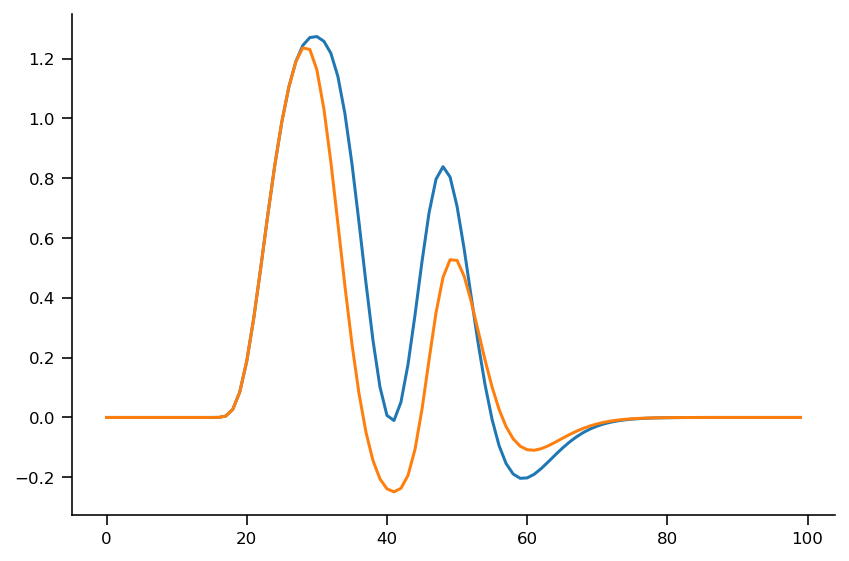

In [43]:
plt.plot(design_matrix_GLM[:,0])
plt.plot(design_matrix_GLM[:,1])

In [46]:
design_matrix_GLM = hrf_convo(design_matrix, canon_hrf)

In [45]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix[0])


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

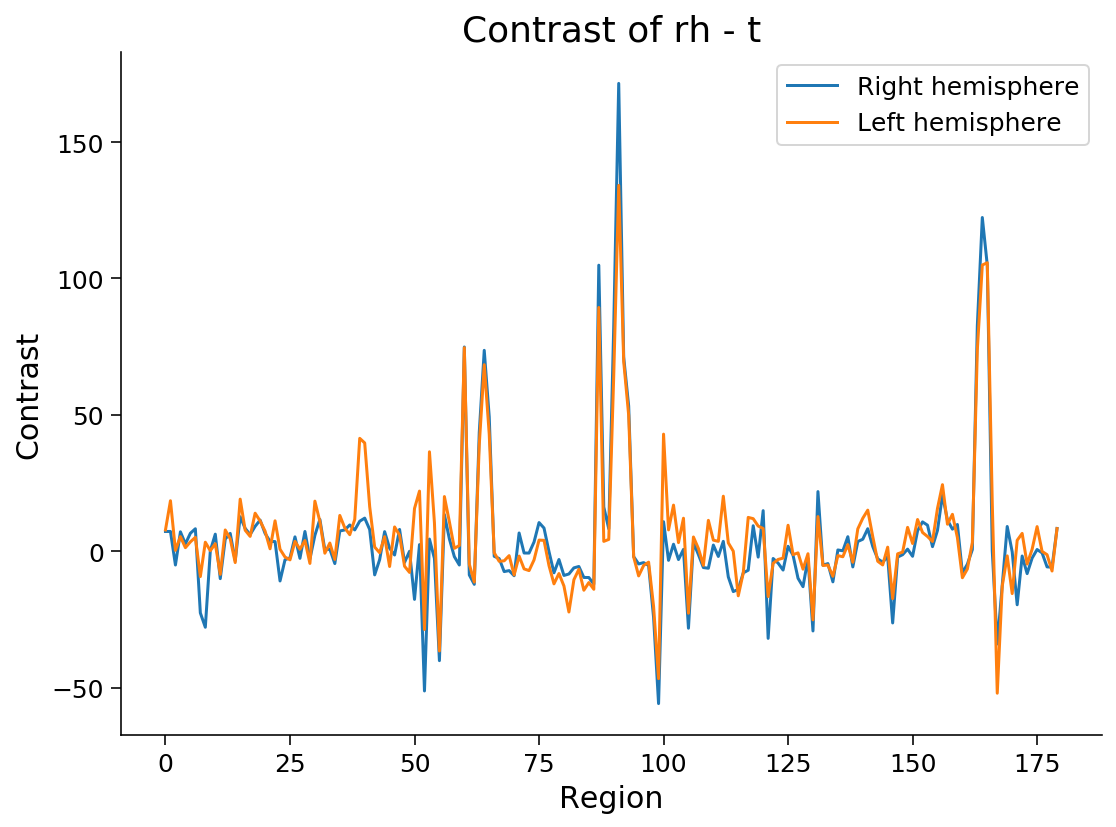

In [20]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

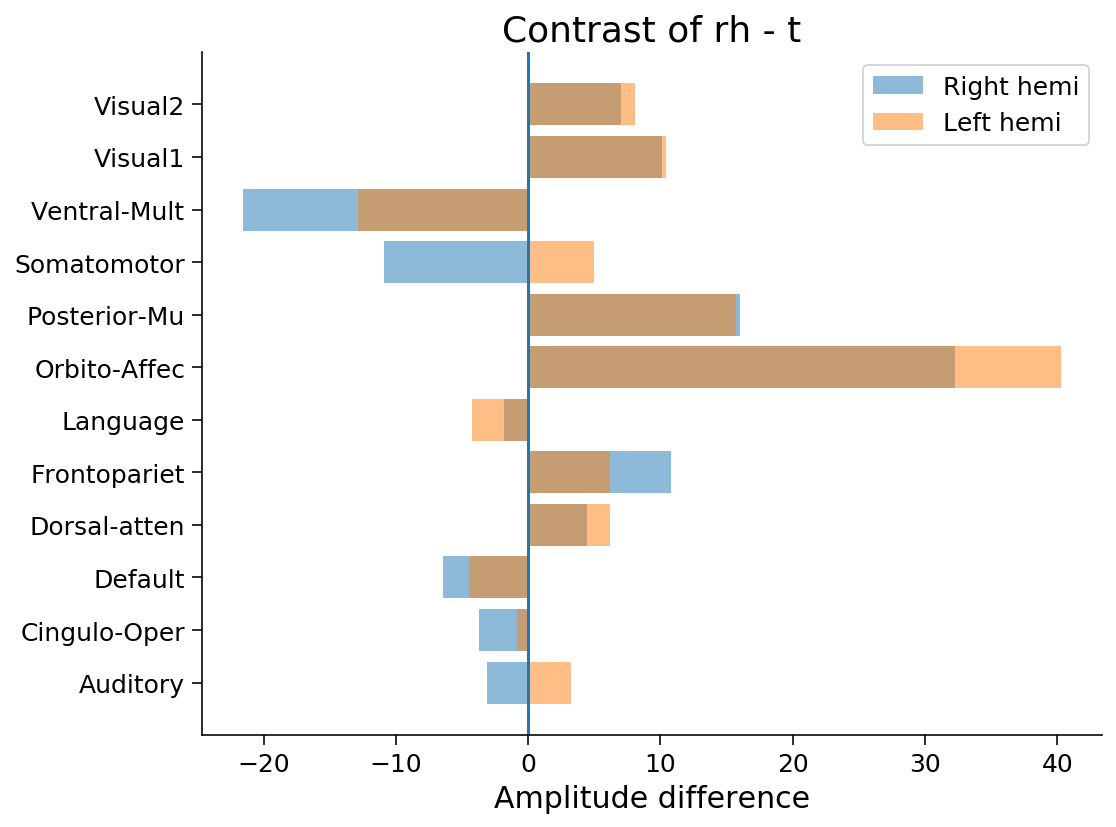

In [21]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

Compute N of errors 

In [59]:
task = 'wm'
import warnings

#ignore by message
warnings.filterwarnings("ignore", message="genfromtxt")
conditions = ['0bk_err', '0bk_nlr', '2bk_err', '2bk_nlr']
conditions2 = ['2bk_nlr']
Totalerrorcount = np.zeros([len(subjects),len(conditions)])
c = -1
for condition in conditions:
    c += 1
    xx = 0
    for subject in subjects:
        '''Get number of erroneous trials'''
        for id in get_image_ids(task):
            task_key = BOLD_NAMES[id - 1]
            ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
            x = np.genfromtxt(ev_file)
            n_errors = x.shape[0]
            Totalerrorcount[[subject], [c]] = n_errors
#np.savetxt('/Users/jonathanorschiedt/Documents/Python/Nerrors.txt',Totalerrorcount, fmt='%d', delimiter=',')

In [60]:
evs

[]

In [24]:
np.sum(Totalerrorcount)

3510.0

In [25]:
np.sum(Totalerrorcount, axis=0)

array([ 938.,  341., 1608.,  623.])

In [ ]:
# Regressors:

# Correct omission of response
# Correct response (i.e. repetition of stimulus n trials back
# Omission Error
# Wrong response
# Motion regressors
# Run-number
# Constant
# Instructions
# Stimulus Presentation Onset
# Rest?